In [2]:
#Importing necessary packages
import pandas as pd
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
import random
import math

### Loading the Data

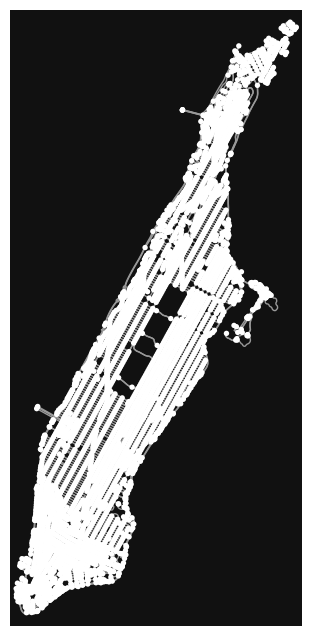

In [3]:
#Dowloading the Manhattan street network and visualizing it
G = ox.graph_from_place("Manhattan, New York, USA", network_type="drive")
fig, ax = ox.plot.plot_graph(G)

In [4]:
#Loading the data with the firehouse coordinates
firehouse_listing = pd.read_csv("FDNY_Firehouse_Listing_20250401.csv")

In [5]:
#Extracting the information of Manhattan fire stations only
manhattan_firestations = firehouse_listing[firehouse_listing["Borough"] == "Manhattan"]
manhattan_firestations

,FacilityName,FacilityAddress,Borough,Postcode,Latitude,Longitude,Community Board,Community Council,Census Tract,BIN,BBL,NTA
0,Engine 4/Ladder 15,42 South Street,Manhattan,10005,40.703694,-74.007717,101,1,7,1000867,1000350001,Battery Park City-Lower Manhattan
1,Engine 6,49 Beekman Street,Manhattan,10038,40.709971,-74.005395,101,1,1501,1001287,1000930030,Battery Park City-Lower Manhattan
2,Manhattan Borough Command/Battalion 1/Engine 7...,100 Duane Street,Manhattan,10007,40.715339,-74.006300,101,1,33,1001647,1001500025,SoHo-TriBeCa-Civic Center-Little Italy
3,Ladder 8,14 N. Moore Street,Manhattan,10013,40.719574,-74.006620,101,1,33,1002150,1001890035,SoHo-TriBeCa-Civic Center-Little Italy
4,Engine 9/Ladder 6,75 Canal Street,Manhattan,10002,40.715408,-73.992834,103,1,16,1003898,1003000030,Chinatown
5,Battalion 4/Engine 15/Ladder 18,25 Pitt Street,Manhattan,10002,40.716439,-73.983927,103,1,12,1004078,1003420060,Lower East Side
6,Engine 28/Ladder 11,222 East 2 Street,Manhattan,10009,40.721879,-73.982526,103,2,2202,1004608,1003850058,Lower East Side
7,Engine 5,340 East 14 Street,Manhattan,10003,40.731494,-73.983407,103,2,40,1006520,1004550028,East Village
8,Division 1/Ladder 20,253 Lafayette Street,Manhattan,10012,40.723026,-73.996571,102,1,43,1007523,1004950007,SoHo-TriBeCa-Civic Center-Little Italy
9,Engine 33/Ladder 9,42 Great Jones Street,Manhattan,10012,40.726986,-73.992526,102,1,5502,1008526,1005310049,West Village


In [6]:
#converting graph to projected form - enables easier data handling, especially for compatability with the pandas dataframe
G_proj = ox.project_graph(G)

In [7]:
#converting the fire station dataframe to geodataframe
geometry = [Point(xy) for xy in zip(manhattan_firestations["Longitude"], manhattan_firestations["Latitude"])]
gdf_firestations = gpd.GeoDataFrame(manhattan_firestations, geometry=geometry, crs="EPSG:4326")

#projecting to the same as the projection graph
gdf_firestations_proj = gdf_firestations.to_crs(G_proj.graph['crs'])

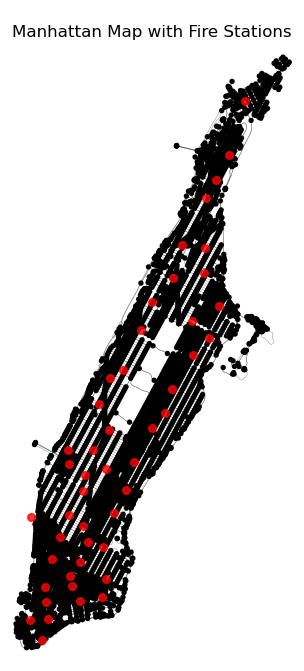

In [8]:
#plotting
fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor="white", edge_color="black", edge_alpha=0.5, 
                        node_color="black", edge_linewidth=0.3)
gdf_firestations_proj.plot(ax=ax, color='red', markersize=30, alpha=0.8, zorder=3)
plt.title("Manhattan Map with Fire Stations")
plt.show()

Here, we are just overlaying the location of the fire stations on the map. The fire stations are not nodes yet.

### Constructing the graph

Constructing a weighted graph:

In [9]:
G_weighted = nx.DiGraph() #directed because streets have directions (e.g. one way streets) and weighted because of their lengths

for u, v, data in G_proj.edges(data=True):
    weight = data.get('length', 1) #defaults to 1 if the length is missing
    G_weighted.add_edge(u, v, weight=weight)

for node, data in G_proj.nodes(data=True): #adding the nodes from the data
    G_weighted.add_node(node, **data)

Finding the nearest node in the graph to represent each firehouse (ensures every firehouse is actually at an acceptable/valid point on the map)

In [10]:
firehouse_nodes = ox.distance.nearest_nodes(
    G_proj,
    X=gdf_firestations_proj.geometry.x,
    Y=gdf_firestations_proj.geometry.y
)

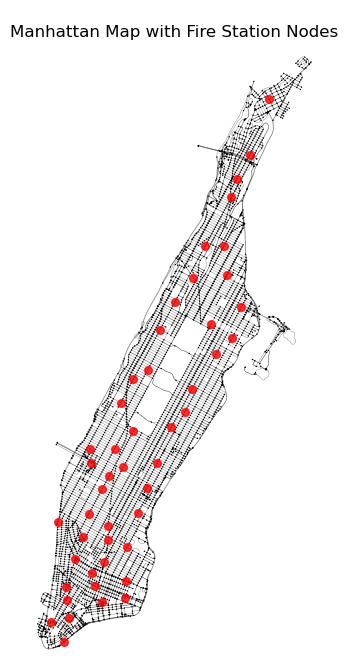

In [11]:
#plotting the ACTUAL fire station nodes:
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
firehouse_x = [node_positions[node][0] for node in firehouse_nodes]
firehouse_y = [node_positions[node][1] for node in firehouse_nodes]

fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor='white',
                        edge_color='black', edge_alpha=0.5,
                        node_color='black', node_size=1,
                        edge_linewidth=0.3)
ax.scatter(firehouse_x, firehouse_y, c='red', s=30, alpha=0.8, zorder=3, label='Firehouse')
plt.title("Manhattan Map with Fire Station Nodes")
plt.show()

### Simulating an Emergency

Choosing 3 distinct emergency locations and compute the minimum response time from the closest fire station.

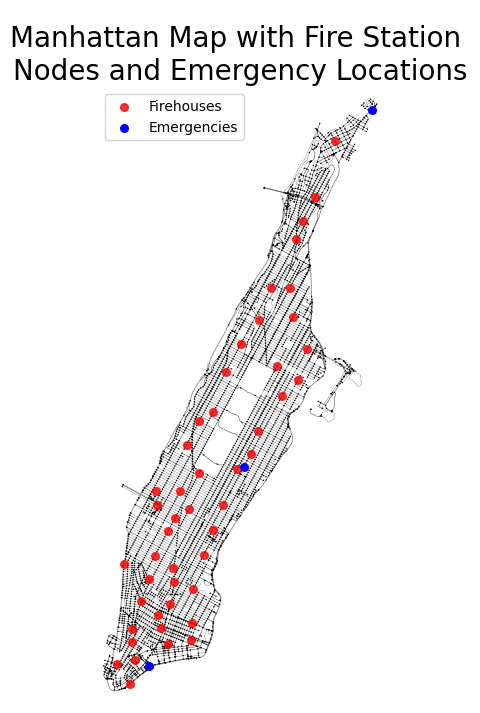

In [36]:
#we choose 3 nodes at random
random.seed(3) #for reproducibility
emergency_nodes = random.sample(list(G_weighted.nodes), 3) #choose 3 nodes

#plotting
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
firehouse_x = [node_positions[node][0] for node in firehouse_nodes] #firehouse coordinates
firehouse_y = [node_positions[node][1] for node in firehouse_nodes]
emergency_x = [node_positions[node][0] for node in emergency_nodes] #emergency coordinates
emergency_y = [node_positions[node][1] for node in emergency_nodes]

fig, ax = ox.plot_graph(G_proj, show=False, close=False, bgcolor='white',
                        edge_color='black', edge_alpha=0.5,
                        node_color='black', node_size=1,
                        edge_linewidth=0.3)
ax.scatter(firehouse_x, firehouse_y, c='red', s=30, alpha=0.8, zorder=3, label='Firehouses')
ax.scatter(emergency_x, emergency_y, c='blue', s=30, zorder=3, label='Emergencies')
plt.title("Manhattan Map with Fire Station \nNodes and Emergency Locations", size = 20)
ax.legend()
plt.show()

Now, we can apply shortest path algorithms (Dijkstra's and A-star) to calculate the minimum distance from the firehouses to the emergency location.

We begin by using Dijkstra's algorithm (we have positive path lengths only, so we can use this algorithm)

In [13]:
#we do this in order to only select paths that are actually the shortest
#initializing lists
paths = []
distances = []

for emergency in emergency_nodes: #for loop that computes the path for each emergency node
    min_distance = float("inf") #initializing values that will be updated
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes: #for loop that goes through all of the firehouses 
        try:
            distance, path = nx.single_source_dijkstra(G_proj, source = firehouse, target=emergency, weight = "length") #specifies using dijkstras alg
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath: #if there is no path, continue looking
            continue
    
    if best_path is not None: #so if we have found a best path
        paths.append(best_path)
    if min_distance is not float("inf"): #so if we have found a best path
        distances.append(min_distance)

print(len(paths)) #this should be 3 because we have 3 emergency nodes
print(paths)
print(distances)

3
[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[608.8185127851767, 917.7797061705894, 1712.590888141085]


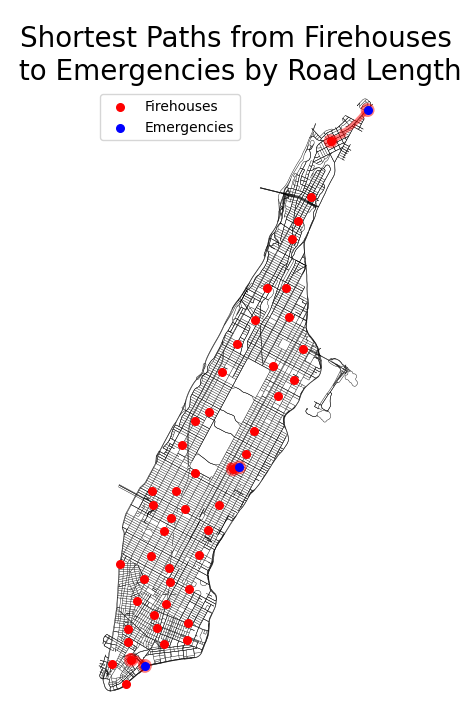

In [14]:
#plotting
fig, ax = ox.plot_graph_routes(G_proj, routes=paths, route_color='blue', route_linewidth=2, node_size=0, bgcolor='white', show=False, close=False, edge_color='black', edge_linewidth=0.3)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}
firehouse_x = [node_positions[n][0] for n in firehouse_nodes]
firehouse_y = [node_positions[n][1] for n in firehouse_nodes]
emergency_x = [node_positions[n][0] for n in emergency_nodes]
emergency_y = [node_positions[n][1] for n in emergency_nodes]
ax.scatter(firehouse_x, firehouse_y, c='red', s=30, label='Firehouses', zorder=3)
ax.scatter(emergency_x, emergency_y, c='blue', s=30, label='Emergencies', zorder=3)
plt.title("Shortest Paths from Firehouses\n to Emergencies by Road Length", size = 20)
ax.legend(loc="upper left")
plt.show()

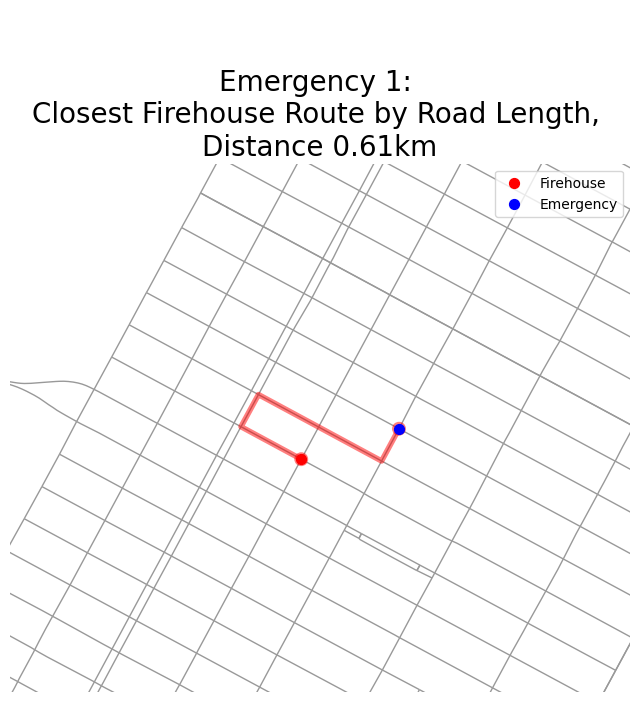

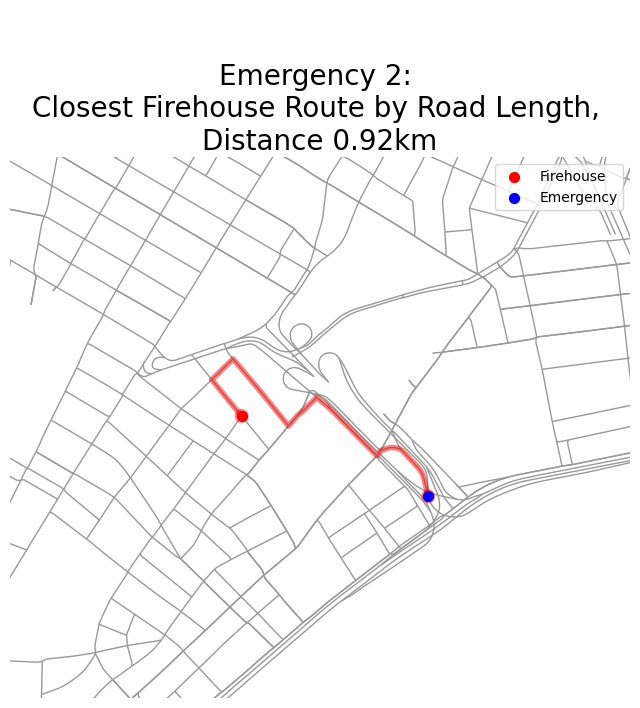

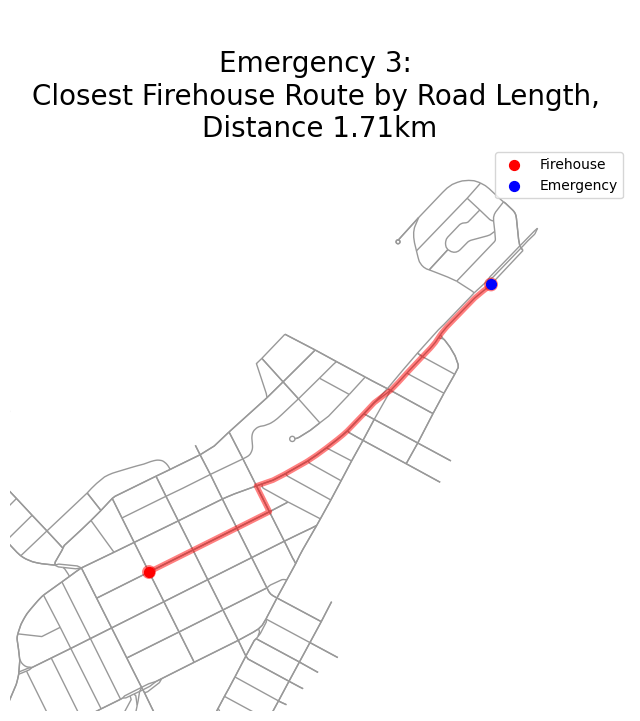

In [15]:
#we want to zoom in to visualize the paths better:

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(paths):
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}: \nClosest Firehouse Route by Road Length, \nDistance {round(distances[idx]/1000, 2)}km", size = 20)
    ax.legend()
    plt.show()


Comments:

The first one looks unneccessarily long, but this can happen because:
* OSMnx (the library used) uses actual physical distances, and the route it chose could be the one that minimzes the length (the map might be misleading)
* OSMnx takes into account one-way streets - it could be that the street that "looks shorter" cannot be travelled on because it is a one way street.

In [16]:
G_proj.is_directed() #the graph is directed

True

In [17]:
#visualizing what attributes the edges have:
firehouse_node = 42437433
list(G_proj.out_edges(firehouse_node, data=True))

[(42437433,
  42437428,
  {'osmid': 945384088,
   'highway': 'residential',
   'maxspeed': '25 mph',
   'name': 'East 67th Street',
   'oneway': True,
   'reversed': False,
   'length': 147.93177529759768,
   'geometry': <LINESTRING (587390.853 4513434.842, 587381.797 4513439.776, 587366.973 4513...>,
   'lanes': '1'}),
 (42437433,
  42447069,
  {'osmid': 945384089,
   'highway': 'secondary',
   'name': 'Lexington Avenue',
   'oneway': True,
   'reversed': False,
   'length': 79.61733899261314,
   'geometry': <LINESTRING (587390.853 4513434.842, 587387.54 4513428.752, 587356.094 45133...>,
   'lanes': '2'})]

We do therefore see that both are actually one-way streets and therefore this could be why the route that looks the shortest is not taken.

#### A-star

First, we will simply use the euclidean distance as the heuristic.

3
[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[608.8185127851767, 917.7797061705894, 1712.590888141085]


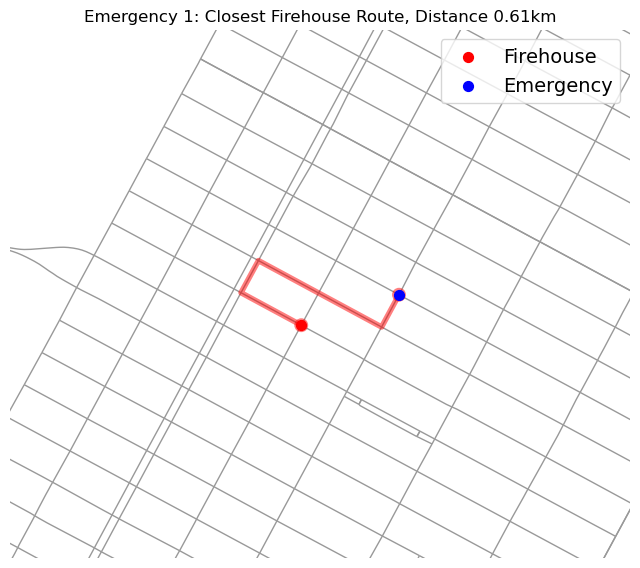

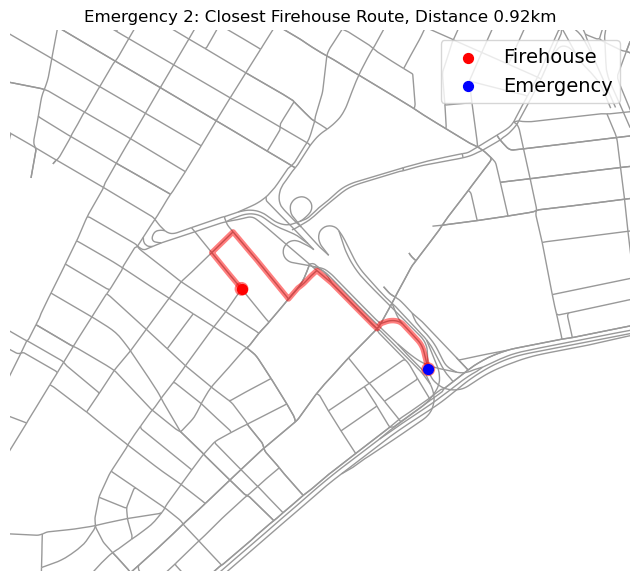

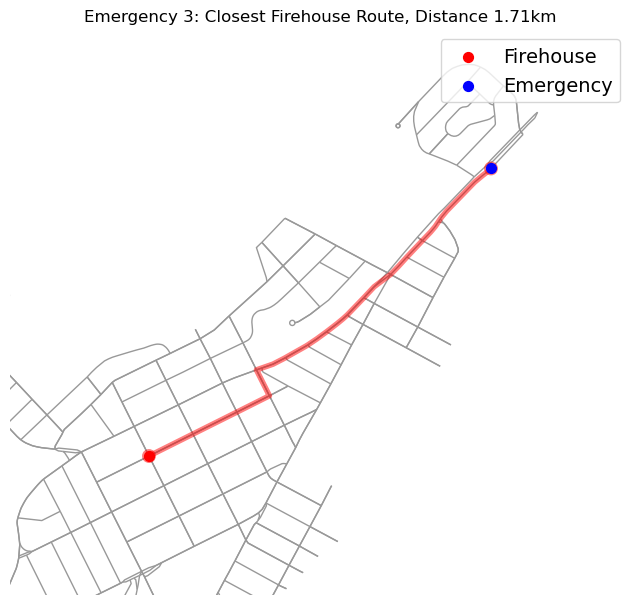

In [18]:
def euclidean_heuristic(u, v):
    ux, uy = G_proj.nodes[u]['x'], G_proj.nodes[u]['y']
    vx, vy = G_proj.nodes[v]['x'], G_proj.nodes[v]['y']
    return math.hypot(ux - vx, uy - vy)

a_paths = []
a_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            path = nx.astar_path(G_proj, source=firehouse, target=emergency, heuristic=euclidean_heuristic, weight='length')
            distance = nx.path_weight(G_proj, path, weight = "length")
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath: #if there is no path, continue looking
            continue
    
    if best_path is not None:
        a_paths.append(best_path)
    if min_distance is not float("inf"):
        a_distances.append(min_distance)

print(len(a_paths)) #this should be 3 because we have 3 emergency nodes
print(a_paths)
print(a_distances)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(paths):
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}: Closest Firehouse Route, Distance {round(distances[idx]/1000, 2)}km")
    ax.legend(fontsize = 14)
    plt.show()


We see that A* and Dijkstras paths do not change, they find the same paths (as expected).

### Shortest Paths by Travel Time

So far, we computed shortest paths using the length, but in emergency scenarios, travel time is also crucial. We therefore now use the travel time, assuming that the max speed attribute of the edges is the speed that the cars go in.

In [19]:
G_proj = ox.add_edge_speeds(G_proj) #estimates speed based on the highway types

In [20]:
G_proj = ox.add_edge_travel_times(G_proj) #adds the travel time in seconds based on speed and length

In [21]:
#now we compute the shortest paths based on the travel times and see if anything changes
time_paths = []
time_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(G_proj, source = firehouse, target=emergency, weight = "travel_time") #specifies using dijkstras alg
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath: #if there is no path, continue looking
            continue
    
    if best_path is not None:
        time_paths.append(best_path)
    if min_distance is not float("inf"):
        time_distances.append(min_distance)

print(len(time_paths)) #this should be 3 because we have 3 emergency nodes
print(time_paths)
print(time_distances)

3
[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[56.44055674715811, 98.40352710607725, 158.63444764053128]


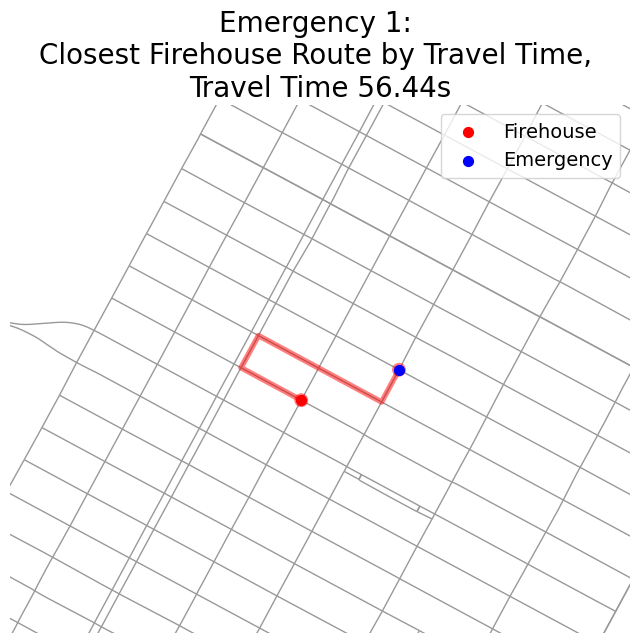

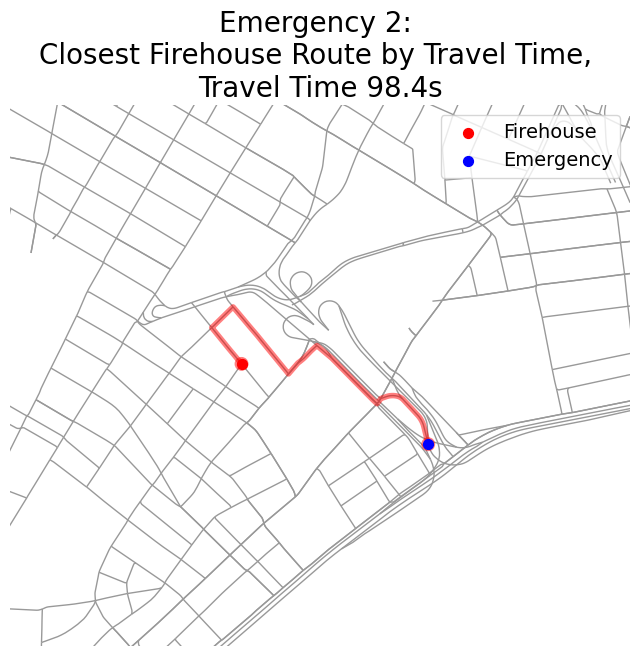

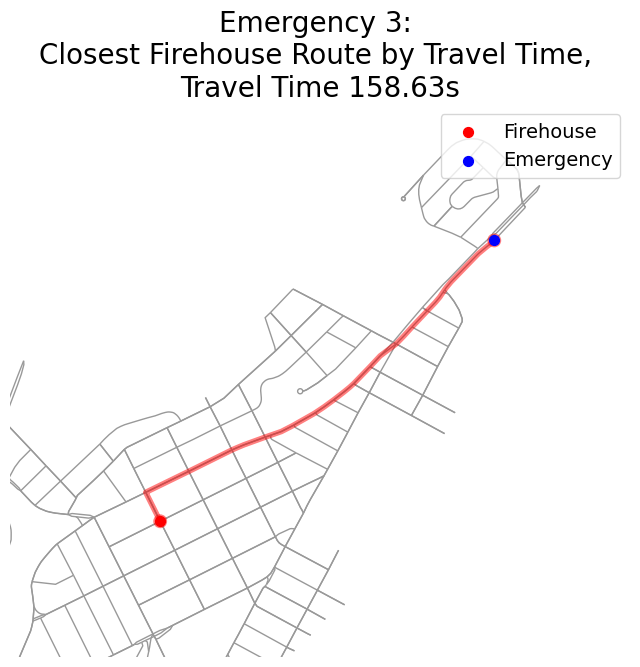

In [22]:
#plotting
node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, time_paths in enumerate(time_paths):
    emergency_node = time_paths[-1]
    firehouse_node = time_paths[0]

    path_x = [node_positions[n][0] for n in time_paths]
    path_y = [node_positions[n][1] for n in time_paths]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[time_paths],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}: \nClosest Firehouse Route by Travel Time, \nTravel Time {round(time_distances[idx], 2)}s", size = 20)
    ax.legend(fontsize=14)
    plt.show()

These remained mostly similar, except for the third which changed.

### Narrow/Slow Roads

We have the number of lanes each road (edge) has, so we can use less lanes as a penalty, where the less lanes there are the slower it is to use that road.

In [23]:
def compute_penalized_weight(data):
    """
    Computes a weight that penalizes roads that have less lanes
    """
    try:
        lanes_value = data.get("lanes", 1) #if there are no lanes, we default to 1 lane.
        if isinstance(lanes_value, list):
            lanes = sum(float(l) for l in lanes_value if str(l).isdigit()) / len(lanes_value)
        else:
            lanes = float(lanes_value)

        base_speed = data.get("speed_kph", 30)
        if isinstance(base_speed, list):
            base_speed = float(base_speed[0])

        length = data["length"]

        travel_time = length / (base_speed * 1000 / 3600)
        return travel_time * (1 + (1 / lanes))

    except (KeyError, ZeroDivisionError, ValueError, TypeError) as e:
        print(f"Skipping edge due to error: {e}")
        return float("inf")
    
def weight_lanes(data):
    """
    Computes a weight that penalized roads with a lower number of lanes
    """
    try:
        travel_time = data["travel_time"]

        lanes_value = data.get("lanes", 1)
        if isinstance(lanes_value, list):
            lanes = sum(float(l) for l in lanes_value if str(l).isdigit()) / len(lanes_value)
        else:
            lanes = float(lanes_value)

        return travel_time * (1 + (1 / lanes))

    except (KeyError, ZeroDivisionError, ValueError, TypeError) as e:
        print(f"Skipping edge due to error: {e}")
        return float("inf")

def custom_weight_function(u, v, data): #networkx expects it like this
    return weight_lanes(data)
    #return compute_penalized_weight(data)

In [24]:
for u, v, data in G_proj.edges(data=True):
    try:
        data["penalized_weight"] = compute_penalized_weight(data)
    except KeyError:
        data["penalized_weight"] = float("inf")  #if "length" is missing


[[42437433, 42447069, 42447060, 42449985, 5542680310, 42447235, 42437436, 42431680, 42449991], [42421951, 42421946, 42421941, 42453902, 42429844, 42454798, 42427251, 42440350, 42440270, 42444271, 42433229, 42422283, 278609934, 278609863, 278608718], [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[77.23024592700278, 182.85446495703792, 217.14927178245918]


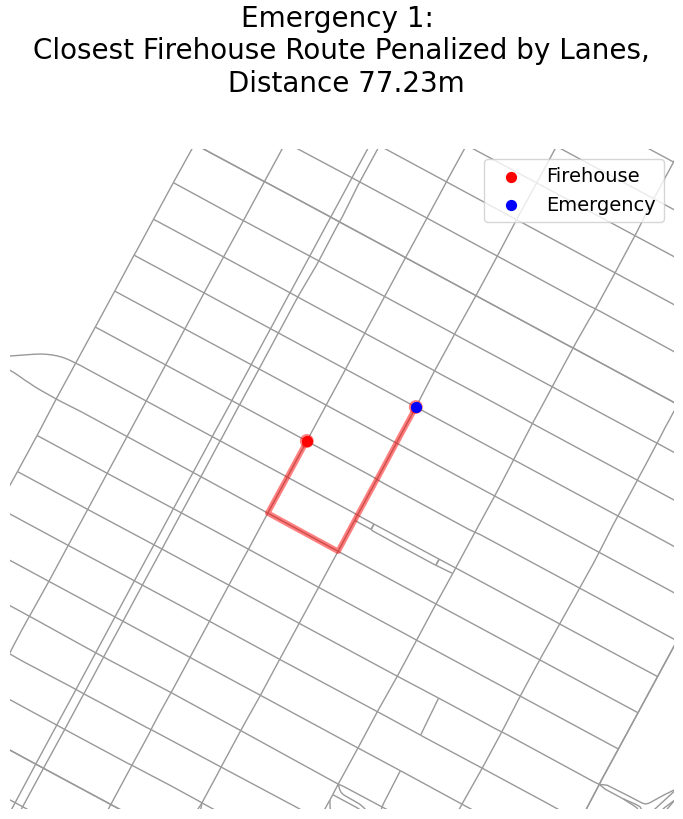

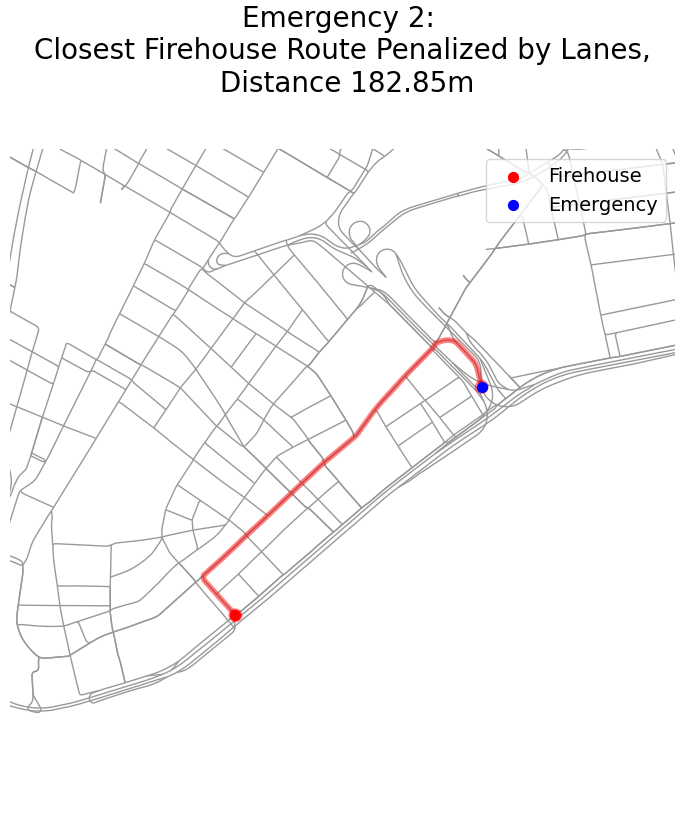

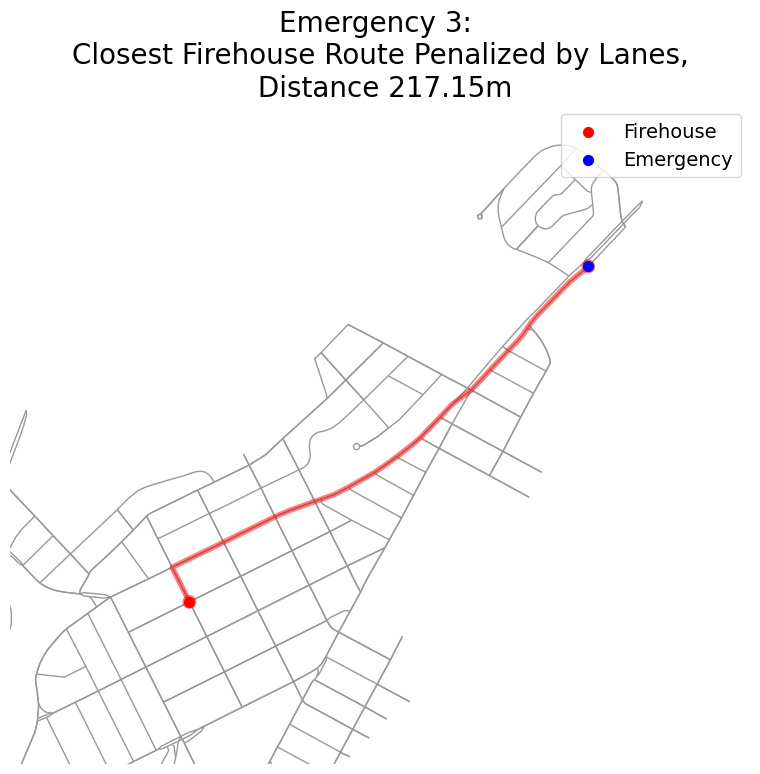

In [25]:
lane_paths = []
lane_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(source=firehouse, target=emergency, G=G_proj, weight="penalized_weight") 
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        lane_paths.append(best_path)
    if min_distance is not float("inf"):
        lane_distances.append(min_distance)

print(lane_paths)
print(lane_distances)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}: \nClosest Firehouse Route Penalized by Lanes,\n Distance {round(lane_distances[idx], 2)}m", fontsize = 20)
    ax.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


We need to be careful here, because this is not the actual distance in meters, but penalized distance as it is the distance multipled by a factor related to the lanes.

We can see that some of the paths have changed. We can look at the number of lanes that the edges in the paths have: 

In [26]:
#printing the number of lanes
lanes_list = []
for idx, path in enumerate(lane_paths):
    print(f"Path {idx+1} (Firehouse {path[0]} → Emergency {path[-1]}):")
    lan = []
    for i in range(len(path) - 1):
        u, v = path[i], path[i+1]
        edge_data = G_proj.get_edge_data(u, v)

        if isinstance(edge_data, dict) and 0 in edge_data:
            edge_data = edge_data[0]

        lanes = edge_data.get("lanes", "N/A")
        print(f"  Edge ({u}, {v}) → Lanes: {lanes}")
        lan.append(lanes)
    print()
    print(lan)
    lanes_list.append(lan)

print(lanes_list)

Path 1 (Firehouse 42437433 → Emergency 42449991):
  Edge (42437433, 42447069) → Lanes: 2
  Edge (42447069, 42447060) → Lanes: 3
  Edge (42447060, 42449985) → Lanes: 2
  Edge (42449985, 5542680310) → Lanes: ['4', '5']
  Edge (5542680310, 42447235) → Lanes: 5
  Edge (42447235, 42437436) → Lanes: 4
  Edge (42437436, 42431680) → Lanes: 4
  Edge (42431680, 42449991) → Lanes: ['4', '5']

['2', '3', '2', ['4', '5'], '5', '4', '4', ['4', '5']]
Path 2 (Firehouse 42421951 → Emergency 278608718):
  Edge (42421951, 42421946) → Lanes: 1
  Edge (42421946, 42421941) → Lanes: 1
  Edge (42421941, 42453902) → Lanes: 4
  Edge (42453902, 42429844) → Lanes: 4
  Edge (42429844, 42454798) → Lanes: 4
  Edge (42454798, 42427251) → Lanes: 4
  Edge (42427251, 42440350) → Lanes: 4
  Edge (42440350, 42440270) → Lanes: 4
  Edge (42440270, 42444271) → Lanes: 4
  Edge (42444271, 42433229) → Lanes: 4
  Edge (42433229, 42422283) → Lanes: 4
  Edge (42422283, 278609934) → Lanes: 4
  Edge (278609934, 278609863) → Lanes: 1

We have some NA values, so we can't know for sure how many lanes that road has.

In [27]:
#computing the average number of lanes
i = 1
for l in lanes_list:
    flattened_lanes = []

    for item in l:
        if isinstance(item, list):
            flattened_lanes.extend(item)
        else:
            flattened_lanes.append(item)

    print(flattened_lanes)
    cleaned_list = [int(item) for item in flattened_lanes if item != 'N/A'] #we ignore the NA element. TODO: check if this is ok
    avg_lanes = sum(cleaned_list) / len(cleaned_list)
    print(f"The average number of lanes for path {i} is {avg_lanes}")
    i = i + 1

['2', '3', '2', '4', '5', '5', '4', '4', '4', '5']
The average number of lanes for path 1 is 3.8
['1', '1', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '1', '1']
The average number of lanes for path 2 is 3.142857142857143
['N/A', '4', '4', '4', '4', '4', '4', '4', '4', '4', '4', '2', '3', '2', '2', '2', '3', '2']
The average number of lanes for path 3 is 3.2941176470588234


## Highway Type

One of the edge attributes we have is the highway type.

In [28]:
highway_types = set()

for _, _, data in G.edges(data=True):
    highway = data.get("highway")
    
    if isinstance(highway, list):  # if it's a list, add each element
        highway_types.update(highway)
    elif isinstance(highway, str):  # if it's a string, just add it
        highway_types.add(highway)

print(highway_types)

{'secondary', 'secondary_link', 'unclassified', 'tertiary_link', 'residential', 'primary', 'tertiary', 'trunk_link', 'living_street', 'motorway', 'motorway_link', 'primary_link', 'trunk'}


Interpreting these highway types (source: https://wiki.openstreetmap.org/wiki/Key:highway):

* **residential**: Roads which serve as an access to housing, without function of connecting settlements. Often lined with housing.
* **secondary**: Often link towns to each other.
* **living_street**: residential streets where pedestrians have legal priority over cars, speeds are kept very low.
* **secondary_link**: The link roads (sliproads/ramps) leading to/from a secondary road from/to a secondary road or lower class highway.
* **motorway**: major highway. the most important.
* **primary_link**: The link roads (sliproads/ramps) leading to/from a primary road from/to a primary road or lower class highway.
* **trunk_link**: The link roads (sliproads/ramps) leading to/from a trunk road from/to a trunk road or lower class highway.
* **trunk**: The most important roads in a country's system that aren't motorways. Second most important roads.
* **tertiary_link**: The link roads (sliproads/ramps) leading to/from a tertiary road from/to a tertiary road or lower class highway.
* **primary**: often link large towns to each other.
* **unclassified**: minor roads of a lower classification than tertiary, but which serve a purpose other than access to properties
* **motorway_link**: The link roads (sliproads/ramps) leading to/from a motorway from/to a motorway or lower class highway.
* **tertiary**: often link smaller towns and villages


From most to least functionally important for motor vehicle traffic:
* motorway
* motorway_link
* trunk
* trunk_link
* primary
* primary_link
* secondary
* secondary_link
* tertiary
* tertiary_link
* unclassified
* residential
* living_street
* unclassified

We can create a score for each of these highway types, and then penalize based on whether the fire trucks use a big road or a small road. 

Are big roads preferable or not? High traffic? Low traffic?

Probably big roads are bad because a lot of cars will be on them... so we would penalize if a road is "important"?

But it could also make sense to prefer to use the bigger roads because we want faster and more direct routes, and larger highways connect more areas to each other, faster.

So we will look at two weight functions:

In [29]:
def penalize_small_highways(data):
    """
    Computes travel time but penalizes it if the road is not important.
    """
    #creating a dictionary that holds the weights for the different highways
    highway_weights = {
        "motorway":1,
        "motorway_link":1.1,
        "trunk":1.2,
        "trunk_link":1.3,
        "primary":1.4,
        "primary_link":1.5,
        "secondary":1.6,
        "secondary_link":1.7,
        "tertiary":1.8,
        "tertiary_link":1.9,
        "unclassified":2,
        "residential":2.1,
        "living_street":2.2,
        "unclassified":2.3    
    }

    try:
        #using travel time, but if there isn't one, we calculate it on our own
        travel_time = data.get('travel_time')
        if travel_time is None:
            speed_kph = data.get("speed_kph", 30)
            if isinstance(speed_kph, list):
                speed_kph = float(speed_kph[0])
            length_m = data.get("length", 0)
            travel_time = length_m / (speed_kph * 1000 / 3600)

        highway = data.get("highway", "unclassified") #if none, say its unclassified (precautionary/assumption we make)
        if isinstance(highway, list):
            highway = highway[0]

        penalty = highway_weights.get(highway, (sum(highway_weights.values()) / len(highway_weights))) #if we do not have any weight, we set it to the average of the weights
        return travel_time * penalty

    except Exception as e:
        print(f"Error computing weight for edge ({u}, {v}): {e}")
        return float("inf")
    


def penalize_large_highways(data):
    """
    Computes travel time but penalizes it if the road is important.
    """
    highway_weights = {
        "unclassified": 1.0,
        "residential": 1.1,
        "living_street": 1.2,
        "tertiary_link": 1.3,
        "tertiary": 1.4,
        "secondary_link": 1.5,
        "secondary": 1.6,
        "primary_link": 1.7,
        "primary": 1.8,
        "trunk_link": 1.9,
        "trunk": 2.0,
        "motorway_link": 2.1,
        "motorway": 2.3
}


    try:
        travel_time = data.get('travel_time')
        if travel_time is None:
            speed_kph = data.get("speed_kph", 30)
            if isinstance(speed_kph, list):
                speed_kph = float(speed_kph[0])
            length_m = data.get("length", 0)
            travel_time = length_m / (speed_kph * 1000 / 3600)


        highway = data.get("highway", "unclassified")
        if isinstance(highway, list):
            highway = highway[0]

        penalty = highway_weights.get(highway, (sum(highway_weights.values()) / len(highway_weights)))
        return travel_time * penalty

    except Exception as e:
        print(f"Error computing weight for edge ({u}, {v}): {e}")
        return float("inf")


In [30]:
for u, v, data in G_proj.edges(data=True):
    try:
        data["large_road_weight"] = penalize_large_highways(data)
    except KeyError:
        data["large_road_weight"] = float("inf")  #if errors happen
    
    try:
        data["small_road_weight"] = penalize_small_highways(data)
    except KeyError:
        data["small_road_weight"] = float("inf")  #if errors happen
    

If we penalize small roads most:

[[42437433, 42447069, 42447060, 42449985, 5542680310, 42447235, 42437436, 42431680, 42449991], [42448593, 42456492, 42443844, 1272562931, 42448469, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42429217, 42429220, 42429222, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[86.0350319856931, 167.22042126540754, 226.79025200901577]


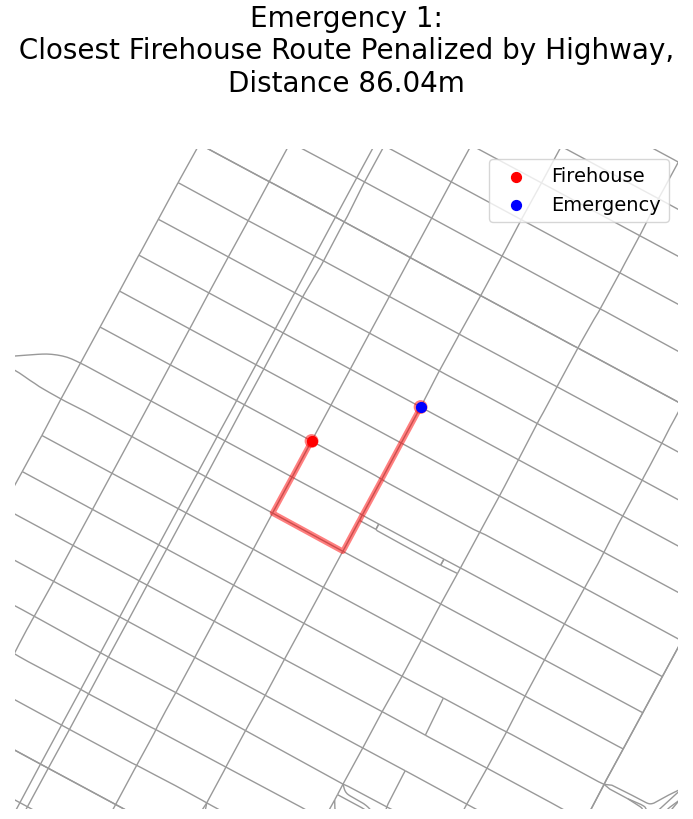

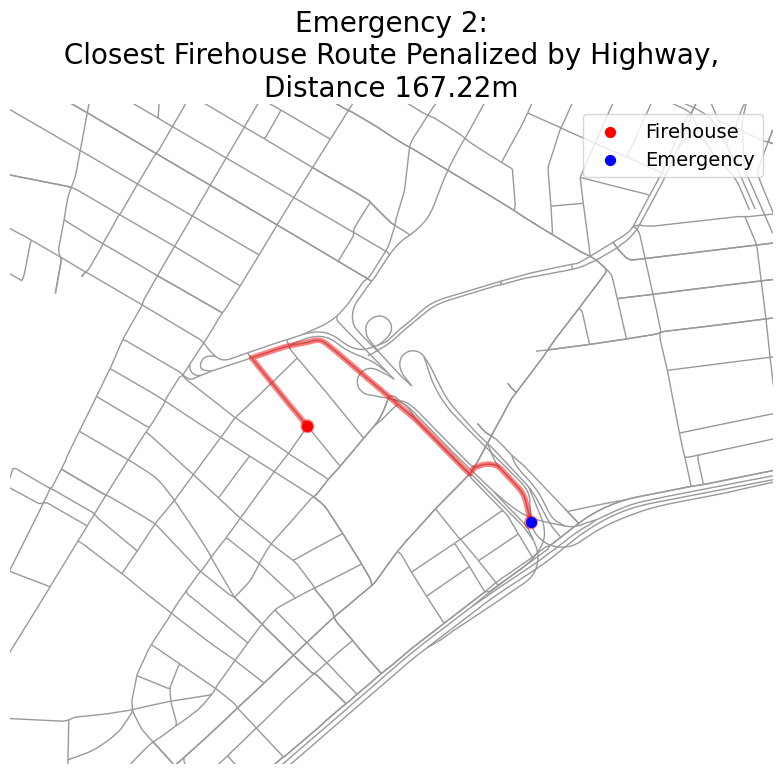

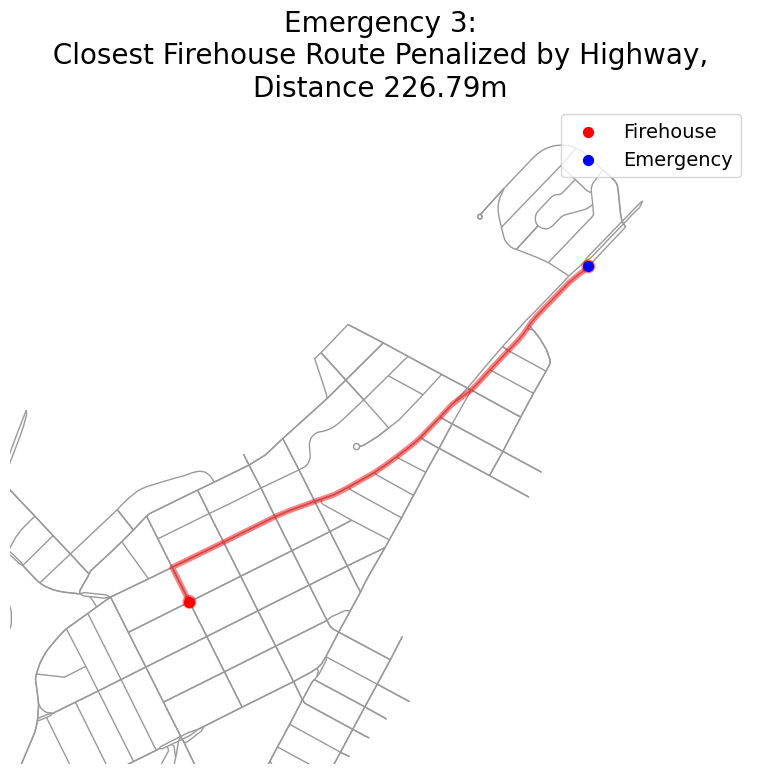

In [31]:
lane_paths = []
lane_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(source=firehouse, target=emergency, G=G_proj, weight="small_road_weight") 
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        lane_paths.append(best_path)
    if min_distance is not float("inf"):
        lane_distances.append(min_distance)

print(lane_paths)
print(lane_distances)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}:\n Closest Firehouse Route Penalized by Highway, \nDistance {round(lane_distances[idx], 2)}m", size = 20)
    ax.legend(fontsize = 14)
    plt.tight_layout()
    plt.show()


Again, not the actual distance, but distance multipled by some factor (Every edge distance is multiplied by a different factor)

Do not change.

If we penalize large roads the most:

[[42437433, 42437428, 42431677, 42431678, 42431680, 42449991], [42448593, 42456492, 42427236, 42427242, 42459820, 42448483, 4158673495, 42422283, 278609934, 278609863, 278608718], [42437921, 42437923, 42431242, 42437925, 42429226, 5071822871, 42429228, 42429231, 42429236, 42429242, 42429244, 1544809886, 42429704, 42429255, 42427507, 1544809889, 1544809882, 42427926]]
[72.1151970068204, 136.7453367203725, 265.97189075776697]


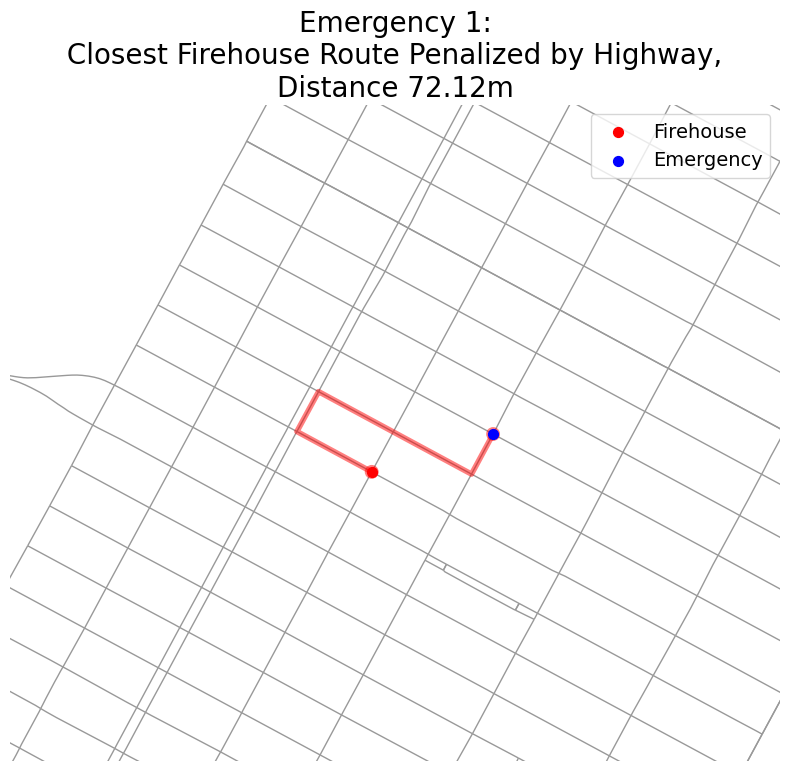

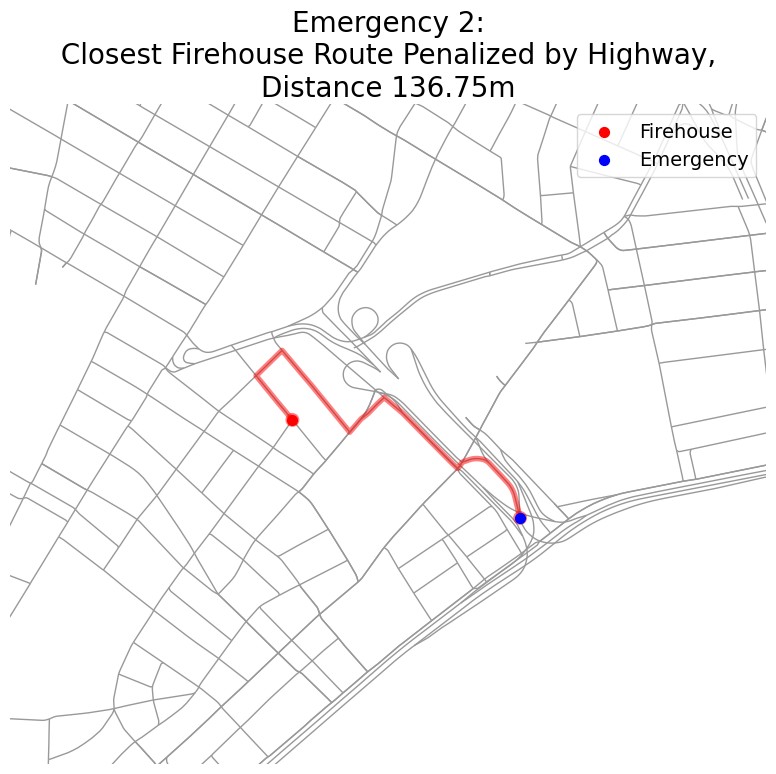

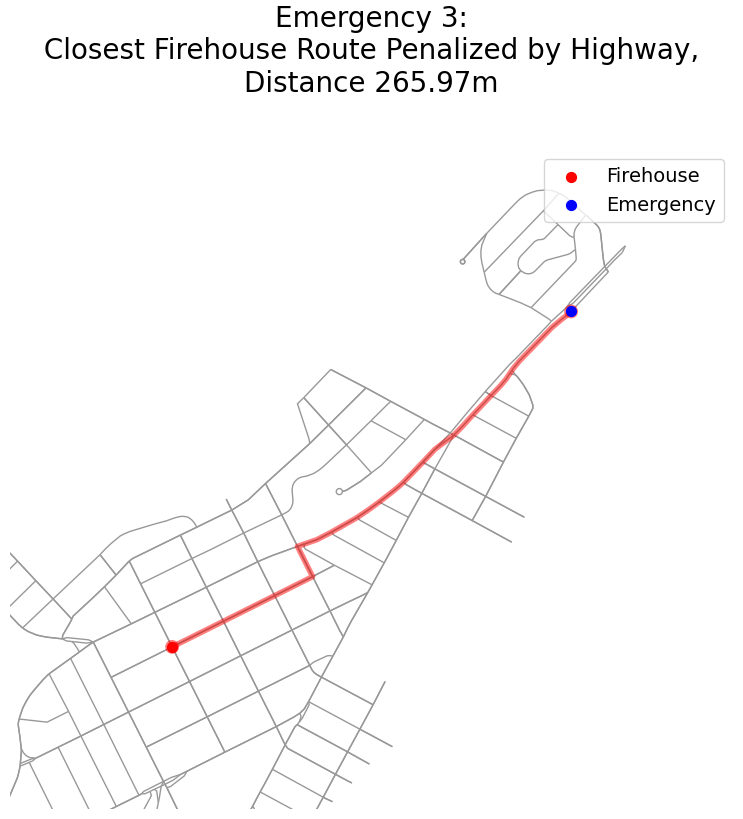

In [32]:
lane_paths = []
lane_distances = []
for emergency in emergency_nodes:
    min_distance = float("inf")
    closest_firehouse = None
    best_path = None
    for firehouse in firehouse_nodes:
        try:
            distance, path = nx.single_source_dijkstra(source=firehouse, target=emergency, G=G_proj, weight="large_road_weight") 
            if distance < min_distance:
                min_distance = distance
                closest_firehouse = firehouse
                best_path = path
        except nx.NetworkXNoPath:
            continue
    
    if best_path is not None:
        lane_paths.append(best_path)
    if min_distance is not float("inf"):
        lane_distances.append(min_distance)

print(lane_paths)
print(lane_distances)

node_positions = {node: (data['x'], data['y']) for node, data in G_proj.nodes(data=True)}

for idx, path in enumerate(lane_paths): 
    emergency_node = path[-1]
    firehouse_node = path[0]

    path_x = [node_positions[n][0] for n in path]
    path_y = [node_positions[n][1] for n in path]

    margin = 500
    minx, maxx = min(path_x) - margin, max(path_x) + margin
    miny, maxy = min(path_y) - margin, max(path_y) + margin

    fig, ax = ox.plot_graph_routes(
        G_proj,
        routes=[path],
        route_color='blue',
        route_linewidth=2,
        node_size=0,
        bgcolor='white',
        show=False,
        close=False
    )
    ax.scatter(node_positions[firehouse_node][0], node_positions[firehouse_node][1],
               c='red', s=50, zorder=3, label='Firehouse')
    ax.scatter(node_positions[emergency_node][0], node_positions[emergency_node][1],
               c='blue', s=50, zorder=3, label='Emergency')

    ax.set_xlim(minx, maxx)
    ax.set_ylim(miny, maxy)

    ax.set_title(f"Emergency {idx+1}:\n Closest Firehouse Route Penalized by Highway, \nDistance {round(lane_distances[idx], 2)}m", size = 20)
    ax.legend(fontsize = 14)
    plt.tight_layout()
    plt.show()


We do see things changing here.

### Extra: Seeing Basic Street Network Stats

Here, we just observe some general properties of the street network we have.

In [38]:
nodes_proj = ox.convert.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.union_all().convex_hull.area
print(graph_area_m)
ox.stats.basic_stats(G_proj, area=graph_area_m, clean_int_tol=15)

85331687.57542239


{'n': 4607,
 'm': 9888,
 'k_avg': 4.2925982200998485,
 'edge_length_total': 1175594.7197782712,
 'edge_length_avg': 118.89105175751124,
 'streets_per_node_avg': 3.5519861080963753,
 'streets_per_node_counts': {0: 0, 1: 102, 2: 28, 3: 1768, 4: 2643, 5: 66},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.02214022140221402,
  2: 0.006077707835901888,
  3: 0.3837638376383764,
  4: 0.5736922075103104,
  5: 0.014326025613197308},
 'intersection_count': 4505,
 'street_length_total': 992241.1003086723,
 'street_segment_count': 8168,
 'street_length_avg': 121.4790769231969,
 'circuity_avg': 1.0203187196387995,
 'self_loop_proportion': 0.0009794319294809011,
 'clean_intersection_count': 3645,
 'node_density_km': 53.98932250024935,
 'intersection_density_km': 52.79398694673829,
 'edge_density_km': 13776.766324223865,
 'street_density_km': 11628.049655430252,
 'clean_intersection_density_km': 42.71566757399802}